# 原始的 Stock Transformer 模型
使用 Bigram Language model 修改的

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import numpy as np

In [6]:
#Transformer 模型
# hyperparameters
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 32  # what is the maximum context length for predictions?
max_iters = 2000  # step 的次數
eval_interval = 100 # 輸出的迭代
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 6
dropout = 0.0
vocab_size = 3000
# ------------

filepath = 'data/tx_data.csv'

df = pd.read_csv(filepath)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
print(df.head())

# 資料處理
torch.manual_seed(1337)

# 載入資料
df = pd.read_csv(filepath)
data_array = df.to_numpy().ravel()
data_array = data_array[(data_array >= 0)] - 14000
data_array = data_array
print(data_array, len(data_array))

# Train and test splits
# 分割training data (90%), val data (10%)
data = torch.tensor(data_array, dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]


# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i + block_size] for i in ix])
    y = torch.stack([data[i + 1:i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)  # (B,T,C)
        q = self.query(x)  # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * C ** -0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)  # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out


class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


# Transformer Decoder
class DecoderBlocks(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        # print('x', x)
        # Reshape the 3D array to 2D by flattening the first two dimensions
        # Get the shape of the 3D array
        d = x.detach().numpy()
        depth, rows, cols = d.shape
        flattened_data = d.reshape((depth * rows, cols))
        np.savetxt('inside transformer/x.csv', flattened_data, delimiter=',', fmt='%f')
        return x


# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.decoder_blocks = nn.Sequential(
            *[DecoderBlocks(n_embd, n_head=n_head) for _ in range(n_layer)])  # 疊 n-layer 層
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # print(idx)
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.decoder_blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)
        # print('loigts',logits)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()) / 1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

   15724
0  15724
1  15725
2  15725
3  15725
4  15724
[1724 1725 1725 ... 2488 2488 2489] 1074796
0.687928 M parameters
step 0: train loss 8.1710, val loss 8.2033
step 100: train loss 6.1919, val loss 7.5807
step 200: train loss 4.8756, val loss 6.8530
step 300: train loss 3.6733, val loss 6.3005
step 400: train loss 2.6676, val loss 5.6051
step 500: train loss 2.1302, val loss 5.0139
step 600: train loss 1.7525, val loss 4.6908
step 700: train loss 1.5469, val loss 4.2853
step 800: train loss 1.3707, val loss 4.1147
step 900: train loss 1.2986, val loss 3.8525
step 1000: train loss 1.2306, val loss 3.4327
step 1100: train loss 1.1552, val loss 3.2887
step 1200: train loss 1.1293, val loss 3.2263
step 1300: train loss 1.0773, val loss 3.2805
step 1400: train loss 1.0876, val loss 3.0967
step 1500: train loss 1.0806, val loss 2.9710
step 1600: train loss 1.0451, val loss 2.9610
step 1700: train loss 1.0413, val loss 2.9450
step 1800: train loss 1.0087, val loss 2.8180
step 1900: train l

In [0]:
# 帶入實際資料生成結果
import matplotlib.pyplot as plt

filepath = 'data/tx_data.csv'
filepath1 = 'data/tx_data0510.csv'
filepath2 = 'data/tx_data0511.csv'
output_data_path = 'output/data.csv'

input_data_count = 2500
output_data_count = 5000

df = pd.read_csv(filepath1)
actual_data = df.to_numpy().ravel()
actual_data = actual_data[(actual_data >= 0)]
input_test_array = actual_data - 14000

context = torch.tensor([[input_test_array[0].astype(int)]])
for i in range(1, input_data_count):
    context1 = torch.tensor([[input_test_array[i].astype(int)]])
    context = torch.cat((context, context1), dim=1)

output = np.array(m.generate(context, max_new_tokens=output_data_count)[0].tolist())
output = output + 14000
print('Output Data: ', output)

# Save the NumPy array to a CSV file
file_name = 'output/data.csv'
np.savetxt(file_name, output, delimiter=',', fmt='%d')

df = pd.read_csv(output_data_path)
output_array = df.to_numpy().ravel()
output_array = output_array[(output_array >= 0)]

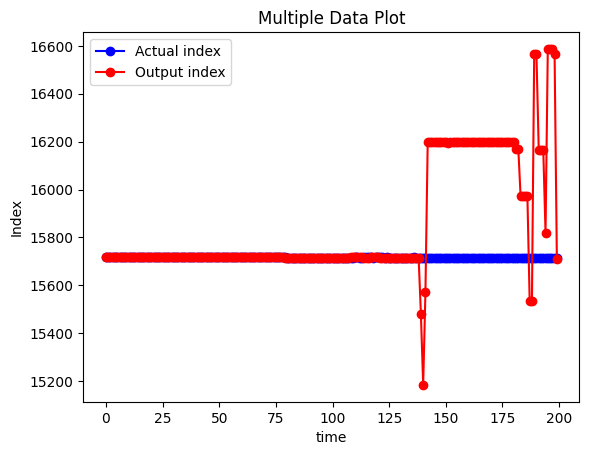

In [9]:
#生成結果繪圖
# 要用來繪圖的兩組數據 data_array1 和 data_array2
s = 2400
n = 2600
data_array1 = actual_data[s:n]
data_array2 = output_array[s:n]

# 創建 x 軸資料，這裡假設 x 軸是數列的索引
x = np.arange(len(data_array1))

# 繪製數據（使用線條圖）
plt.plot(x, data_array1, label='Actual index', marker='o', linestyle='-', c='blue')
plt.plot(x, data_array2, label='Output index', marker='o', linestyle='-', c='red')

# 加入標籤和標題
plt.xlabel('time')
plt.ylabel('Index')
plt.title('Multiple Data Plot')

# 加入圖例
plt.legend()

# 顯示圖表
plt.show()


In [ ]:
import matplotlib.pyplot as plt

filepath = 'data/tx_data.csv'

df = pd.read_csv(filepath)
actual_data = df.to_numpy().ravel()
actual_data = actual_data[(actual_data >= 0)]

# 要用來繪圖的兩組數據 data_array1 和 data_array2
# n = 5000
data_array1 = actual_data

# 創建 x 軸資料，這裡假設 x 軸是數列的索引
x = np.arange(len(data_array1))

# 繪製數據（使用線條圖）
plt.plot(x, data_array1, label='Actual index', marker='o', linestyle='-', c='blue')

# 加入標籤和標題
plt.xlabel('time')
plt.ylabel('Index')
plt.title('Multiple Data Plot')

# 加入圖例
plt.legend()

# 顯示圖表
plt.show()